# Data Format

In [1]:
import pandas as pd
import numpy as np

In [2]:
file = "../estudo_inicial/bases_de_dados/base_de_dados_formatada_rim.csv"

df = pd.read_csv(file)
df = df.drop(columns=["regiao", "data_da_inscricao", "data_do_evento"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47598 entries, 0 to 47597
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   uf               47598 non-null  object 
 1   sexo             47598 non-null  object 
 2   grupo_sanguineo  47598 non-null  object 
 3   cor              47598 non-null  object 
 4   uf_origem        47598 non-null  object 
 5   tipo_de_doador   38331 non-null  object 
 6   idade            47598 non-null  float64
 7   obito_bin        47598 non-null  int64  
 8   transplante_bin  47598 non-null  int64  
 9   delta_t          47598 non-null  float64
dtypes: float64(2), int64(2), object(6)
memory usage: 3.6+ MB


In [3]:
df = df.fillna(0)
df.transplante_bin.loc[df.tipo_de_doador == 0] = 0
df.transplante_bin.loc[df.tipo_de_doador != 0] = 1
df = df.drop(columns=['tipo_de_doador'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47598 entries, 0 to 47597
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   uf               47598 non-null  object 
 1   sexo             47598 non-null  object 
 2   grupo_sanguineo  47598 non-null  object 
 3   cor              47598 non-null  object 
 4   uf_origem        47598 non-null  object 
 5   idade            47598 non-null  float64
 6   obito_bin        47598 non-null  int64  
 7   transplante_bin  47598 non-null  int64  
 8   delta_t          47598 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 3.3+ MB


/tmp/ipykernel_8999/3844140227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.transplante_bin.loc[df.tipo_de_doador == 0] = 0
/tmp/ipykernel_8999/3844140227.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.transplante_bin.loc[df.tipo_de_doador != 0] = 1


In [4]:
np.unique(df.transplante_bin,return_counts=True)

(array([0, 1]), array([ 9267, 38331]))

In [5]:
df_bin = df

bin_cols = [
    "uf",
    # "tipo_de_doador",
    "uf_origem",
    "sexo",
    "grupo_sanguineo",
    "cor",
]

for i,col in enumerate(bin_cols):
    # converting to binary data
    df_one = pd.get_dummies(
        df[col],
        dtype=int
    )


    # Renomeando colunas
    new_columns = [
        col + "_" + category.strip().replace(" ", "_") for category in df_one.columns
    ]

    df_one.columns = new_columns

    df_bin = pd.concat([df_bin, df_one], axis=1)

    df_bin = df_bin.drop(columns=col)

df_bin = df_bin.drop(columns=["delta_t"])

df_bin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47598 entries, 0 to 47597
Data columns (total 65 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idade               47598 non-null  float64
 1   obito_bin           47598 non-null  int64  
 2   transplante_bin     47598 non-null  int64  
 3   uf_AC               47598 non-null  int64  
 4   uf_AL               47598 non-null  int64  
 5   uf_AM               47598 non-null  int64  
 6   uf_BA               47598 non-null  int64  
 7   uf_CE               47598 non-null  int64  
 8   uf_DF               47598 non-null  int64  
 9   uf_ES               47598 non-null  int64  
 10  uf_GO               47598 non-null  int64  
 11  uf_MA               47598 non-null  int64  
 12  uf_MG               47598 non-null  int64  
 13  uf_MS               47598 non-null  int64  
 14  uf_MT               47598 non-null  int64  
 15  uf_PA               47598 non-null  int64  
 16  uf_P

# K-fold

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import pickle as pkl
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()

norm_df = df_bin

norm_df.idade = scaler.fit_transform(df_bin.idade.values.reshape((-1, 1)))

kf = StratifiedKFold(n_splits=5)

X = norm_df.drop(columns=["transplante_bin", "obito_bin"])
y = norm_df[["transplante_bin"]].values

for i, sample in enumerate(y):
    if (sample[0]) != 1 and (sample[0]) != 0:
        print(i, sample[0])

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    fold_dict = {
        "X_train": X.values[train_index, :],
        "X_test": X.values[test_index, :],
        "y_train": y[train_index],
        "y_test": y[test_index],
    }

    with open("folds/fold_{}.pkl".format(i), "wb") as f:
        pkl.dump(fold_dict, f)

# NN model creator

In [12]:
import tensorflow as tf

tf.get_logger().setLevel("INFO")
tf.autograph.set_verbosity(0)

from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import time
from keras import backend as K
import pickle as pkl

2023-12-12 22:11:42.021295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0


In [13]:
class MLP_builder:
    @classmethod
    def add_layer(cls, neurons, ac_function, mlp):
        mlp = tf.keras.layers.Dense(units=neurons, activation=ac_function)(mlp)
        mlp = tf.keras.layers.Dropout(0.2)(mlp)
        return mlp

    def __init__(
        self,
        layers,
        ac_function,
        input_sequence_length,
        batch,
        iterr,
        learningRate,
        beta1,
        beta2,
        epocas,
        output_function="linear",
        shuffle=True,
    ):
        self.layers = layers
        self.ac_function = ac_function
        self.input_sequence_length = input_sequence_length
        self.batch = batch
        self.iterr = iterr
        self.learningRate = learningRate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epocas = epocas
        self.shuffle = shuffle
        self.output_function = output_function

    def fit_predict(self, X_train, y_train, X_test, struct_name, val_split=0.1):
        # print(input_sequence_length)
        input_layer = tf.keras.layers.Input(shape=(self.input_sequence_length,))

        mlp = input_layer  # Inicializar o modelo com a camada de entrada

        for neurons in self.layers:
            self.add_layer(neurons, self.ac_function, mlp)

        # Camada de saída com output_dim=1

        output_function = tf.keras.layers.Dense(1, activation=self.output_function)(mlp)

        # Definir o modelo
        mlp_model = tf.keras.Model(inputs=input_layer, outputs=output_function)

        opt = tf.keras.optimizers.legacy.Adam(
            learning_rate=self.learningRate, beta_1=self.beta1, beta_2=self.beta2
        )

        # Compilar o modelo
        mlp_model.compile(loss="mean_squared_error", optimizer=opt)

        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=val_split, shuffle=self.shuffle, stratify=None
        )

        early_stopping_callback = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=self.iterr,
            verbose=0,
            min_delta=0.0001,
            mode="min",
            restore_best_weights=True,
        )

        start_fit_time = time.time()

        history = mlp_model.fit(
            x=X_train,
            y=y_train,
            batch_size=int(self.batch),
            epochs=self.epocas,
            verbose=0,
            callbacks=[early_stopping_callback],
            # validation_split=0.0,
            validation_data=(X_val, y_val),
            shuffle=self.shuffle,
            workers=10,
            use_multiprocessing=True,
        ).history

        end_fit_time = time.time()

        fit_time = end_fit_time - start_fit_time

        # Ploting Model Loss

        plt.ioff()

        fig, ax = plt.subplots()
        plt.plot(history["loss"], linewidth=2, label="Train")
        plt.plot(history["val_loss"], linewidth=2, label="Validation")
        plt.legend(loc="upper right")
        plt.title("Model loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")

        # plt.show(block=)

        fig.savefig(
            "learning_curves/model-loss__" + struct_name + "__.png",
            bbox_inches="tight",
        )

        del fig

        start_predict_time = time.time()

        output = mlp_model.predict(X_test, workers=10, use_multiprocessing=True)

        end_predict_time = time.time()

        predict_time = end_predict_time - start_predict_time

        K.clear_session()

        return output, fit_time, predict_time

# Grid-search

/home/thiago/anaconda3/lib/python3.10/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/home/thiago/anaconda3/lib/python3.10/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


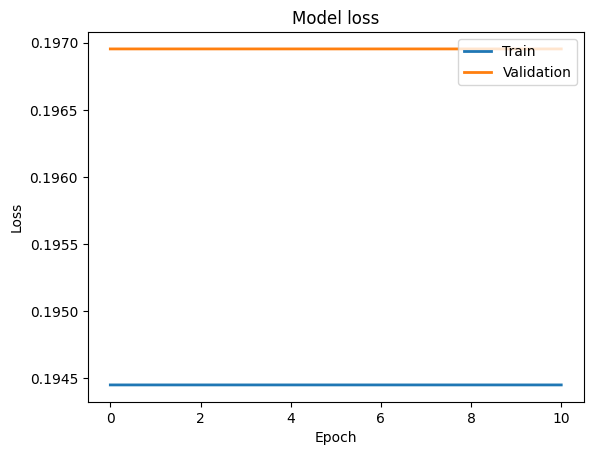

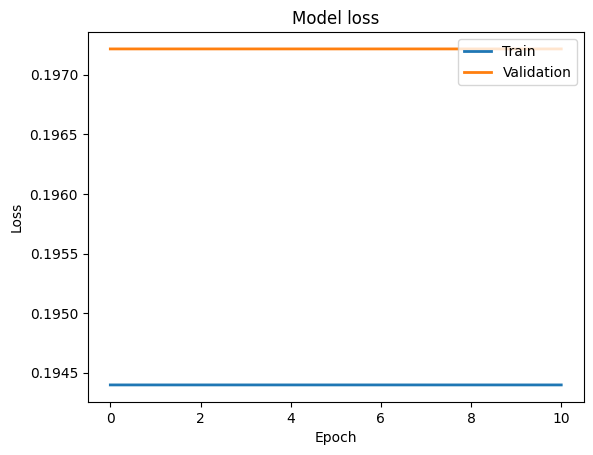

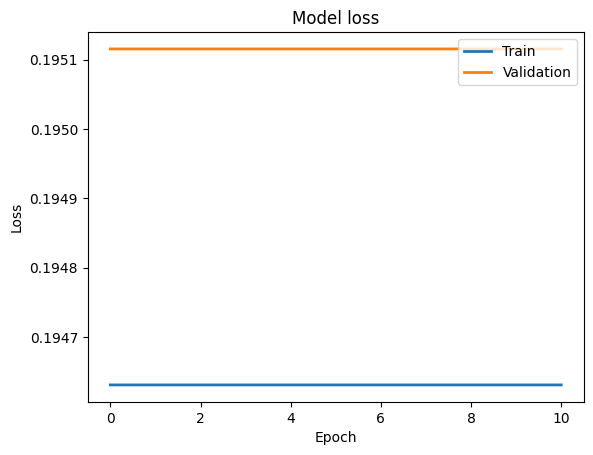

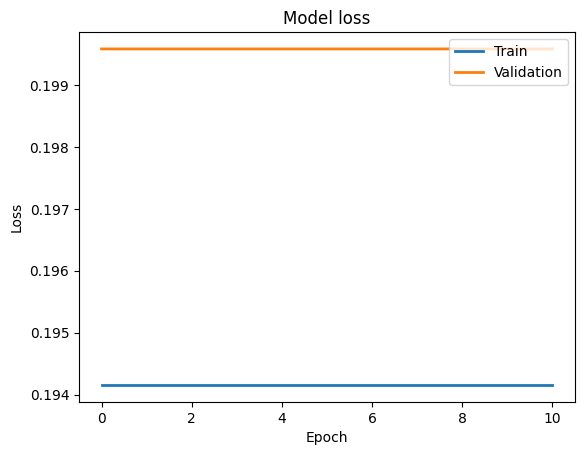

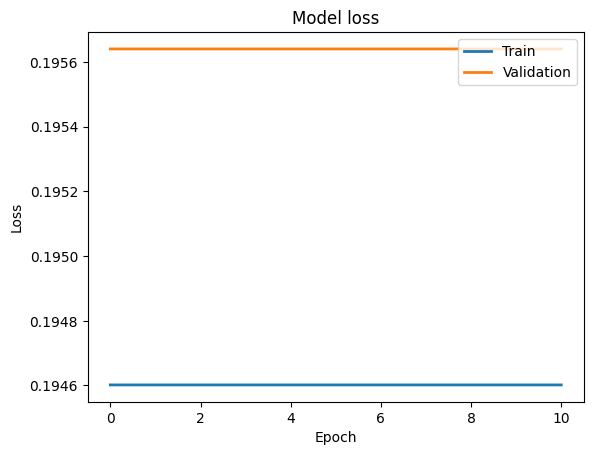

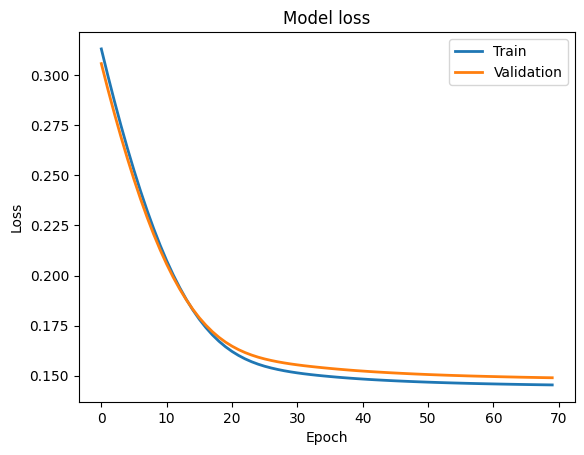

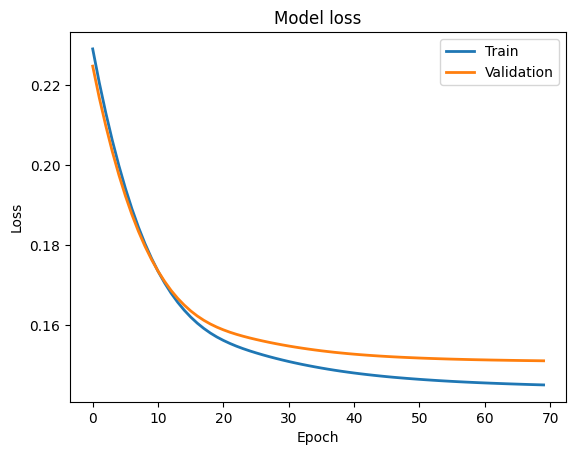

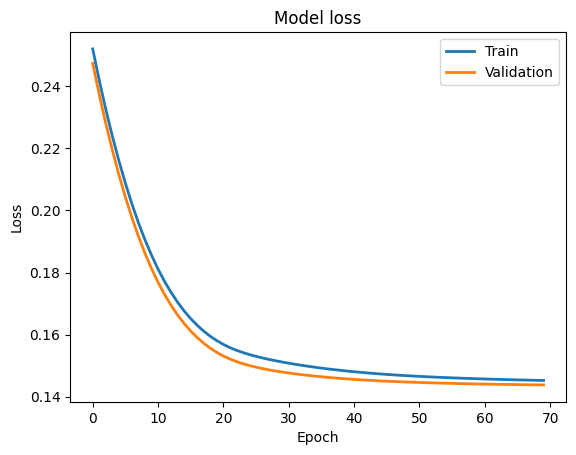

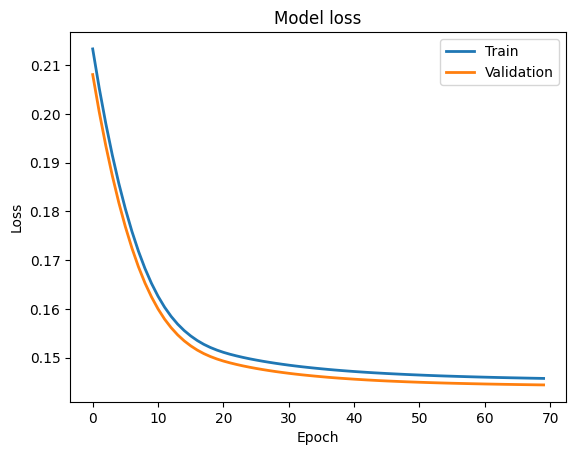

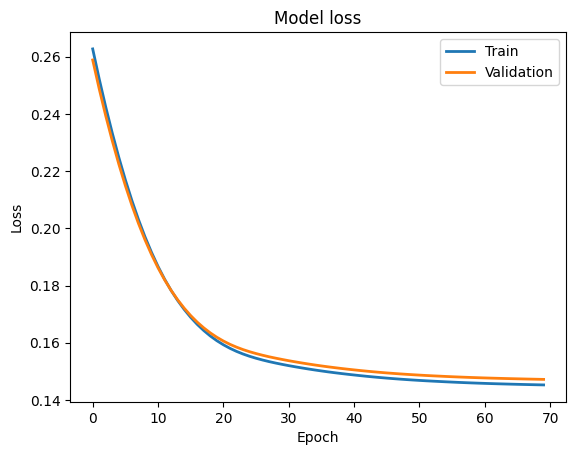

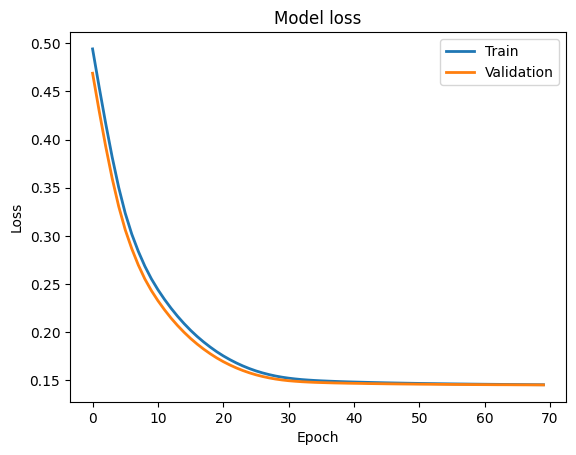

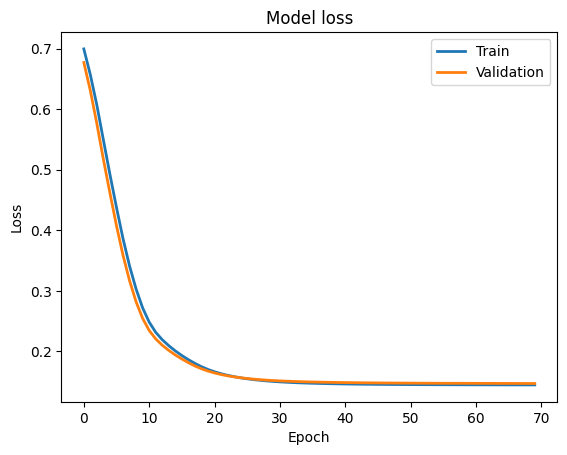

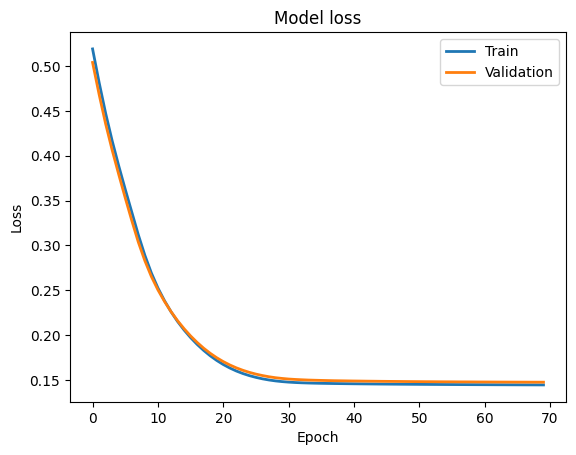

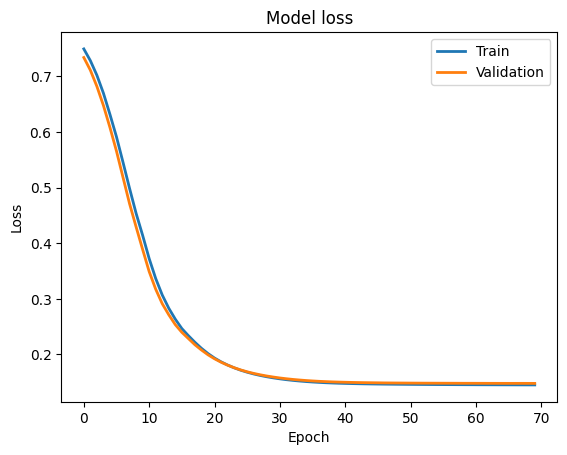

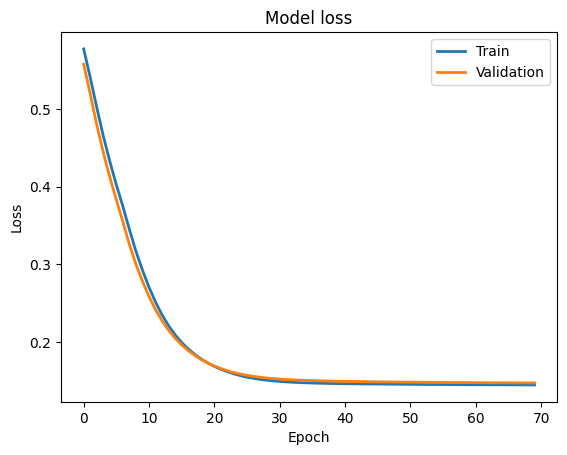

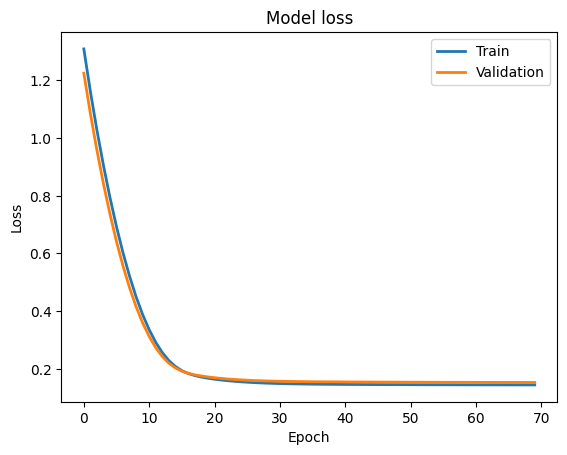

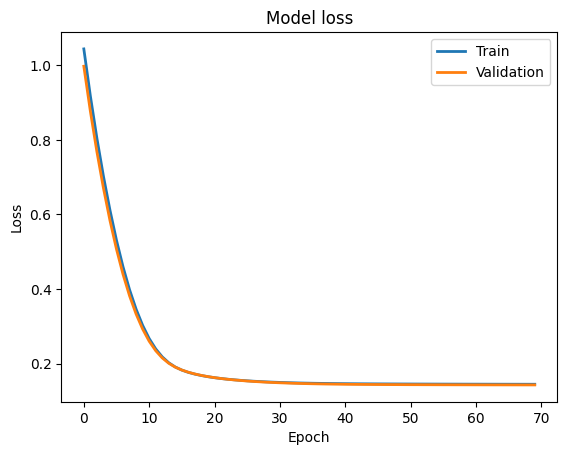

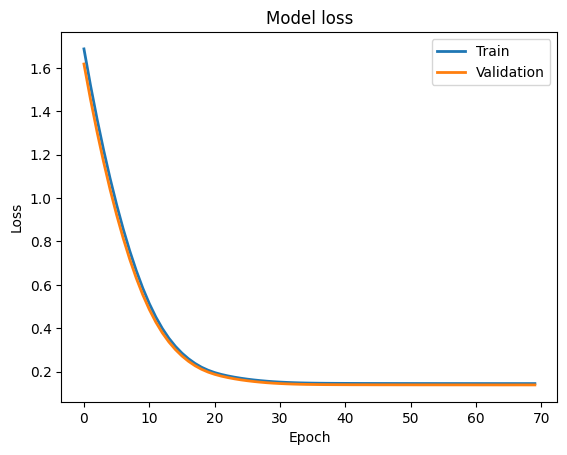

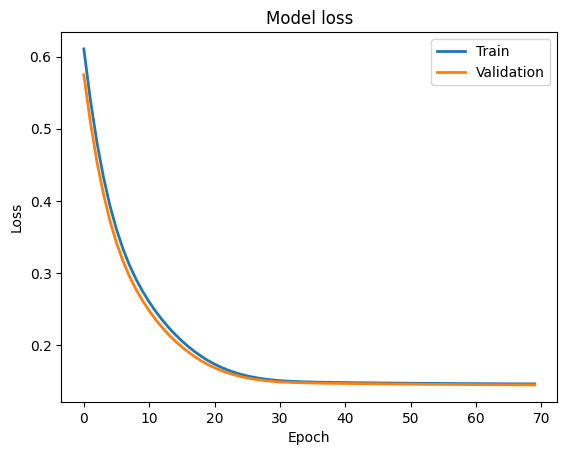

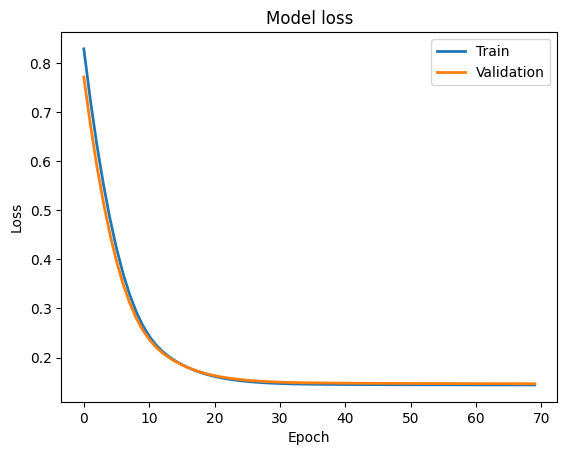

In [14]:
import pickle
import glob
import pandas as pd


hidden_layer_sizes = [
    # (3, 3),
    # (5, 5),
    # (10, 10),
    (3, 3, 3),
    # (5, 5, 5),
    # (10, 10, 10),
]
activation = [
    # "softmax",
    "sigmoid",
    # "tanh",
    # "relu",
    # "linear",
    # "leaky_relu",
    # "softplus",
    # "softsign",
    # "elu",
]

output_function_list = [
    "softmax",
    "sigmoid",
    "relu",
    "linear",
    # "tanh",
    # "leaky_relu",
    # "softplus",
    # "softsign",
    # "elu",
]

batch_size = [
    # 200, 
    300, 
    # 400
    ]
n_iter_no_change = [10]
learningRates = [
    # 0.001,
    0.0001,
    # 0.00001,
    # 0.001,
    # 0.01,
]
beta_1_List = [
    # 0.99,
    0.9,
    # 0.85,
]
beta_2_List = [
    0.99,
    # 0.9,
    # 0.85,
]

results_list = glob.glob("grid_results/*")
folds = glob.glob("folds/*")


for layers in hidden_layer_sizes:
    for function in activation:
        for batch in batch_size:
            for iterr in n_iter_no_change:
                for learningRate in learningRates:
                    for beta1 in beta_1_List:
                        for beta2 in beta_2_List:
                            for output_function in output_function_list:
                                hp_str = "grid_results/sem_tp_doador_layers_{}__activation_function_{}__output_function_{}__batch_{}__iter_{}__LearnR_{}__Beta1_{}__Beta2_{}.pkl".format(
                                    layers,
                                    function,
                                    output_function,
                                    batch,
                                    iterr,
                                    learningRate,
                                    beta1,
                                    beta2,
                                )

                                if learningRate < 0.0001:
                                    epocas = 100

                                else:
                                    epocas = 70

                                if not hp_str in results_list:
                                # try:
                                    global_fit_time = []
                                    global_predict_time = []
                                    model = MLP_builder(
                                        layers,
                                        function,
                                        63,
                                        batch,
                                        iterr,
                                        learningRate,
                                        beta1,
                                        beta2,
                                        epocas=epocas,
                                        output_function=output_function,
                                    )
                                    

                                    for i, fold in enumerate(folds):
                                        with open(fold, "rb") as f:
                                            fold_dict = pickle.load(f)

                                        X_train = fold_dict["X_train"]
                                        y_train = fold_dict["y_train"]
                                        X_test = fold_dict["X_test"]
                                        y_test = fold_dict["y_test"]

                                        (
                                            output,
                                            fit_time,
                                            predict_time,
                                        ) = model.fit_predict(
                                            X_train,
                                            y_train,
                                            X_test,
                                            (
                                                hp_str.split("/")[-1]
                                                + "__fold_{}".format(i)
                                            ),
                                        )

                                        global_fit_time.append(fit_time)
                                        global_predict_time.append(predict_time)

                                        if i == 0:
                                            global_output = output
                                            global_target = y_test

                                        else:
                                            global_output = np.vstack((global_output,output))
                                            global_target = np.vstack((global_target,y_test))


                                    result = {
                                        "y_predict": global_output,
                                        "y_test": global_target,
                                        "fit_time": [np.mean(global_fit_time)],
                                        "predict_time": [
                                            np.mean(global_predict_time)
                                        ],
                                    }

                                    with open(hp_str, "wb") as handle:
                                        pkl.dump(result, handle)

                                    # except:
                                    #     pass

# Read Results

In [88]:
import glob

In [89]:
results_list = glob.glob("grid_results/*")

df_result = False
for i, file in enumerate(results_list):
    if i == 0:
        df_result = pd.read_csv(file).drop(columns="Unnamed: 0")

        hp_serie = pd.DataFrame({"hyperparameters": [file.split("/")[-1]]})

        penalty_score = pd.DataFrame(
            {"penalty_score": df_result.rmse.values + df_result['std'].values}
        )

        df_result = pd.concat(
            (df_result, penalty_score,hp_serie), axis=1
        )

        df_result.index = [i]

    else:
        df_aux = pd.read_csv(file).drop(columns="Unnamed: 0")

        hp_serie = pd.DataFrame({"hyperparameters": [file.split("/")[-1]]})

        penalty_score = pd.DataFrame(
            {"penalty_score": df_aux.rmse.values + df_aux['std'].values}
        )

        df_aux = pd.concat(
            (df_aux, penalty_score,hp_serie), axis=1
        )
        
        df_aux.index = [i]

        df_result = pd.concat((df_result, df_aux), axis=0)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [ ]:
df_result.sort_values(by=["penalty_score"], ascending=True).head()

,rmse,std,fit_time,predict_time,penalty_score,hyperparameters
0,0,0,0.0,0.0,0,"layers_(3, 3)__function_relu__batch_400__iter_..."
1086,0,0,0.0,0.0,0,"layers_(10, 10)__function_relu__batch_200__ite..."
1085,0,0,0.0,0.0,0,"layers_(5, 5, 5)__function_softmax__batch_400_..."
1084,0,0,0.0,0.0,0,"layers_(3, 3, 3)__function_sigmoid__batch_200_..."
1083,0,0,0.0,0.0,0,"layers_(5, 5, 5)__function_linear__batch_300__..."
